In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N/assignments/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment3/cs231n/datasets
/content


# Network Visualization (PyTorch)

В этой записной книжке мы рассмотрим использование *градиентов изображения* для создания новых изображений. 

При обучении модели мы определяем функцию потерь, которая измеряет наше текущее недовольство эффективностью модели; затем мы используем обратное распространение для вычисления градиента потерь по отношению к параметрам модели и выполняем градиентный спуск по параметрам модели, чтобы минимизировать потери. 

Здесь мы поступим немного иначе. Мы начнем с модели сверточной нейронной сети, которая была предварительно обучена для выполнения классификации изображений в наборе данных ImageNet. Мы будем использовать эту модель, чтобы определить функцию потерь, которая количественно определяет наше текущее недовольство нашим изображением, а затем использовать обратное распространение для вычисления градиента этих потерь по отношению к пикселям изображения. Затем мы сохраним модель фиксированной и выполним градиентный спуск *по изображению*, чтобы синтезировать новое изображение, которое минимизирует потери. 

В этой записной книжке мы рассмотрим три метода создания изображений: 

1. **Saliency Maps**: Карты значимости — это быстрый способ определить, какая часть изображения повлияла на решение о классификации, принятое сетью. 
2. **Fooling Images**: мы можем исказить входное изображение, чтобы оно выглядело одинаково для людей, но было неправильно классифицировано предварительно обученной сетью. 
3. **Class Visualization**: мы можем синтезировать изображение, чтобы максимизировать оценку классификации определенного класса; это может дать нам некоторое представление о том, что ищет сеть, когда она классифицирует изображения этого класса. 

В этом ноутбуке используется **PyTorch**; мы предоставили еще одну записную книжку, в которой исследуются те же концепции в TensorFlow. Вам нужно заполнить только одну из этих двух тетрадей.

In [2]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Helper Functions

Наша предварительно обученная модель обучалась на предварительно обработанных изображениях путем вычитания среднего значения для каждого цвета и деления на стандартное отклонение для каждого цвета. Мы определяем несколько вспомогательных функций для выполнения и отмены этой предварительной обработки в ```cs23n/net_visualization_pytorch```. Вам не нужно ничего делать здесь.

In [3]:
from cs231n.net_visualization_pytorch import preprocess, deprocess, rescale, blur_image

# Pretrained Model

Для всех наших экспериментов по созданию изображений мы начнем со сверточной нейронной сети, которая была предварительно обучена для выполнения классификации изображений в ImageNet. Здесь мы можем использовать любую модель, но для целей этого задания мы будем использовать SqueezeNet [1], которая обеспечивает точность, сравнимую с AlexNet, но со значительно уменьшенным количеством параметров и вычислительной сложностью.

Использование SqueezeNet вместо AlexNet, VGG или ResNet означает, что мы можем легко проводить все эксперименты по созданию изображений на CPU. 

[1] Iandola et al, «SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size», arXiv 2016

In [4]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load some ImageNet images

Мы предоставили несколько примеров изображений из проверочного набора данных ImageNet ILSVRC 2012 Classification. Чтобы загрузить эти изображения, перейдите в `cs231n/datasets/` и запустите `get_imagenet_val.sh`.

Поскольку они взяты из проверочного набора, наша предварительно обученная модель не видела эти изображения во время обучения.

Запустите следующую ячейку, чтобы визуализировать некоторые из этих изображений вместе с их метками истинности.

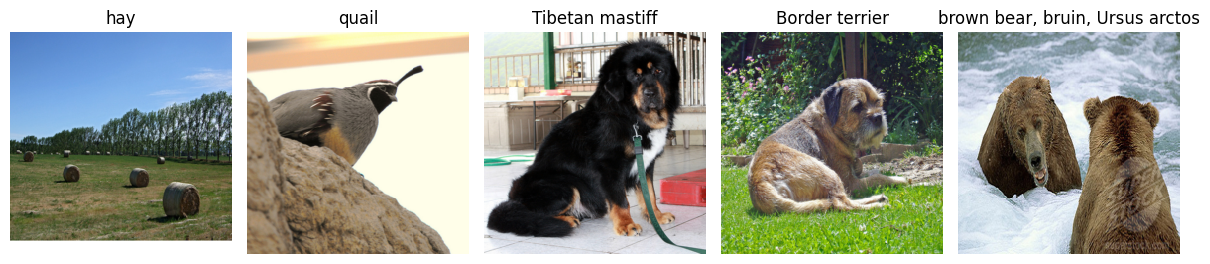

In [5]:
from cs231n.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps
Используя эту предварительно обученную модель, мы будем вычислять карты значимости классов, как описано в разделе 3.1 книги [2].

**Карта значимости** сообщает нам, в какой степени каждый пиксель изображения влияет на классификационную оценку этого изображения. Чтобы вычислить это, мы вычисляем градиент ненормализованной оценки, соответствующей правильному классу (который является скаляром) по отношению к пикселям изображения. Если изображение имеет форму `(3, H, W)`, то этот градиент также будет иметь форму `(3, H, W)`; для каждого пикселя изображения этот градиент сообщает нам величину, на которую изменится оценка классификации, если пиксель изменится на небольшую величину. Чтобы вычислить карту значимости, мы берем абсолютное значение этого градиента, затем берем максимальное значение по 3 входным каналам; Таким образом, окончательная карта значимости имеет форму `(H, W)`, и все записи неотрицательны.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method

Напомним, что в задании 1 вам нужно было выбрать по одному элементу из каждой строки матрицы; если `s` представляет собой nampy массив формы `(N, C)`, а `y` представляет собой numpy массив формы `(N,`), содержащий целые числа `0 <= y[i] <C`, то `s [np.arange(N), y]` представляет собой массив numpy формы `(N,)`, который выбирает один элемент из каждого элемента в `s`, используя индексы в `y`.


В PyTorch вы можете выполнить ту же операцию, используя метод `gather()`. Если `s` является тензором PyTorch формы `(N, C)`, а `y` является тензором PyTorch формы `(N,)`, содержащим long значения в диапазоне `0 <= y[i] <C`, тогда 

`s.gather(1, y.view(-1, 1)).squeeze()` 

будет тензором PyTorch формы `(N,)`, содержащим по одной записи из каждой строки `s`, выбранной в соответствии с индексами в `y`. 

запустите следующую ячейку, чтобы увидеть пример. 

Вы также можете прочитать документацию по [методу gather](http://pytorch.org/docs/torch.html#torch.gather) и [методу squeeze](http://pytorch.org/docs/torch. html#torch.squeeze).

In [6]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-0.4676, -1.3689, -0.5324, -0.1334, -1.0342],
        [-0.5957, -0.9473,  0.4782,  0.4298,  0.0674],
        [ 2.8150, -1.7083,  0.0215,  0.5867,  0.2700],
        [-0.3544,  0.5437,  0.5308,  0.7961,  0.3403]])
tensor([1, 2, 1, 3])
tensor([-1.3689,  0.4782, -1.7083,  0.7961])


Реализуйте ```compute_saliency_maps``` функцию внутри ```cs231n/net_visualization_pytorch.py```

In [7]:
# Load saliency maps computation function
from cs231n.net_visualization_pytorch import compute_saliency_maps


После того, как вы завершили реализацию выше, запустите следующее, чтобы визуализировать некоторые карты значимости классов на наших примерах изображений из набора проверки ImageNet:

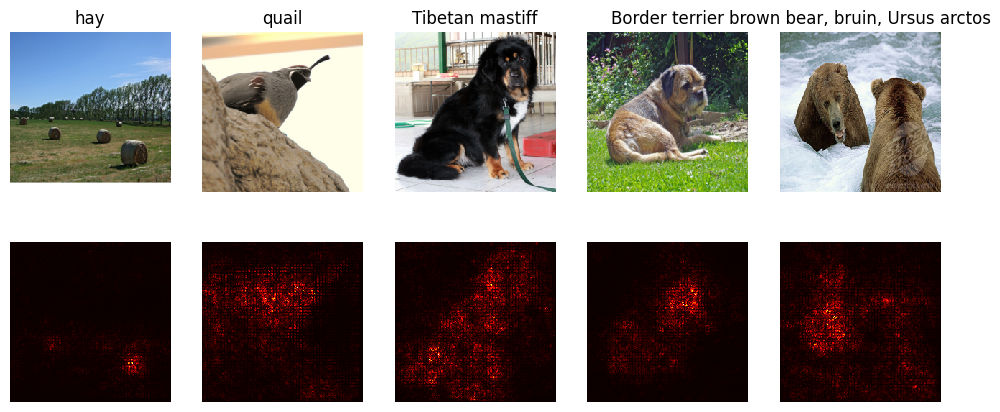

In [8]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

# INLINE QUESTION

Ваш друг предлагает, чтобы найти изображение, которое максимизирует правильную оценку, мы можем выполнить градиентное восхождение по входному изображению, но вместо градиента мы можем фактически использовать карту значимости на каждом шаге для обновления изображения. Верно ли это утверждение? Почему или почему нет?

**Ответ:**
Это утверждение не верно, так как каждое значение на карте значимости вычисляется как максимум (по RGB каналам) от *абсолютных* значений производных. А это значит что если использовать карту значимости для обновления изображения при градиентном *восхождении*, то значения пикселов которые соответствуют отрицательным производным будут увеличены. А так как производные по этим пикселям отрицательные, то значение функции оценки будет уменьшено при увеличении значений этих пикселов.



# Fooling Images

Мы также можем использовать градиенты изображения для создания «обманывающих изображений», как обсуждалось в [3]. Имея изображение и целевой класс, мы можем выполнить градиентное **восхождение** по изображению, чтобы максимизировать целевой класс, останавливаясь, когда сеть классифицирует изображение как целевой класс. Реализуйте следующую функцию для создания обманчивых изображений. 

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014. 

Реализуйте функцию `make_fooling_image` внутри `cs231n/net_visualization_pytorch.py.`

Запустите следующую ячейку, чтобы создать fooling image. В идеале вы не должны видеть на первый взгляд существенной разницы между исходным и обманчивым изображением, и теперь сеть должна сделать неверный прогноз относительно обманчивого изображения. Однако вы должны увидеть небольшой случайный шум, если посмотрите на увеличенную в 10 раз разницу между исходным и ложным изображениями. Не стесняйтесь изменять переменную `idx`, чтобы исследовать другие изображения.

In [9]:
from cs231n.net_visualization_pytorch import make_fooling_image
idx = 0
target_y = 6 

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Номер итерации  0
Номер итерации  1
Номер итерации  2
Номер итерации  3
Номер итерации  4
Номер итерации  5
Номер итерации  6
Номер итерации  7
Номер итерации  8


После создания обманчивого изображения запустите следующую ячейку, чтобы визуализировать исходное изображение, обманчивое изображение, а также разницу между ними.

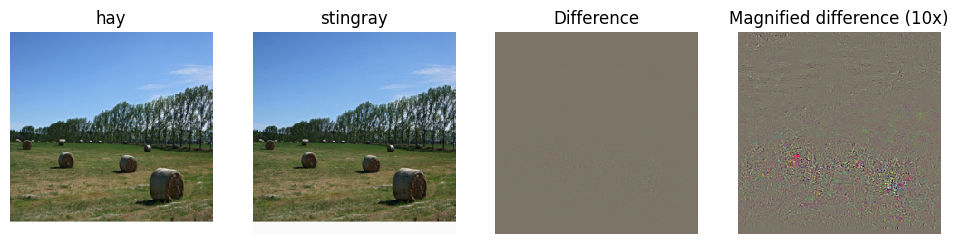

In [10]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization
Начав с изображения случайного шума и выполнив градиентное восхождение для целевого класса, мы можем сгенерировать изображение, которое сеть распознает как целевой класс. Впервые эта идея была представлена в [2]; [3] расширили эту идею, предложив несколько методов регуляризации, которые могут улучшить качество генерируемого изображения. 

Конкретно, пусть $I$ будет изображением, а $y$ будет целевым классом. Пусть $s_y(I)$ будет оценкой, которую сверточная сеть присваивает изображению $I$ для класса $y$; обратите внимание, что это необработанные ненормализованные оценки, а не вероятности класса. Мы хотим сгенерировать изображение $I^*$, которое наберет высокий балл для класса $y$, решив задачу

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

где $R$ — регуляризатор (возможно, неявный) (обратите внимание на знак $R(I)$ в argmax: мы хотим минимизировать этот член регуляризации). Мы можем решить эту проблему оптимизации, используя градиентное восхождение, вычисляя градиенты по отношению к сгенерированному изображению. Мы будем использовать (явную) регуляризацию L2 вида

$$
R(I) = \lambda \|I\|_2^2
$$

**и** неявную регуляризацию, предложенную в [3], путем периодического размытия сгенерированного изображения. Мы можем решить эту проблему, используя градиентное восхождение на сгенерированном изображении.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop


В `cs231n/net_visualization_pytorch.py` завершите реализацию `image_visualization_update_step`, используемую в функции `create_class_visualization` ниже. После того, как вы завершили эту реализацию, запустите следующие ячейки, чтобы сгенерировать изображение тарантула:

In [11]:
from cs231n.net_visualization_pytorch import class_visualization_update_step, jitter, blur_image
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

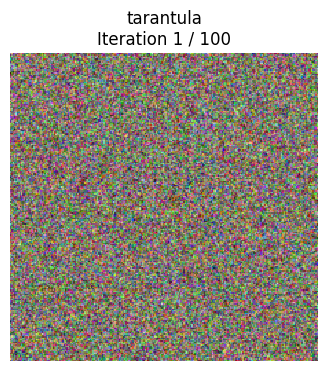

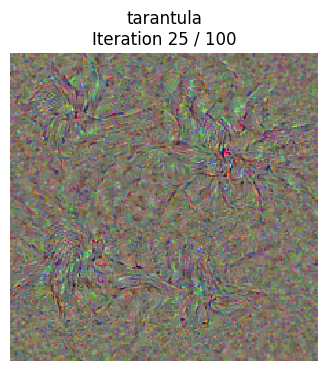

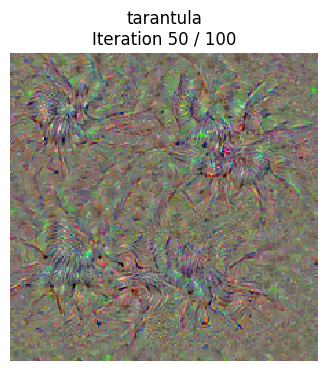

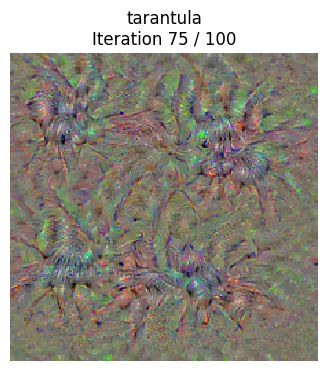

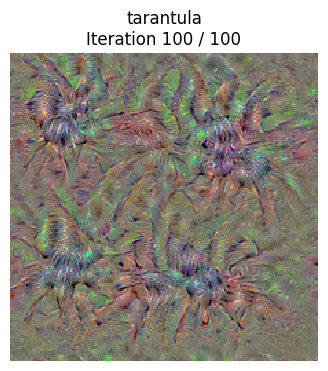

In [15]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)


Попробуйте визуализацию класса на других классах! Вы также можете свободно экспериментировать с различными гиперпараметрами, чтобы попытаться улучшить качество сгенерированного изображения, но это не обязательно.

gorilla, Gorilla gorilla


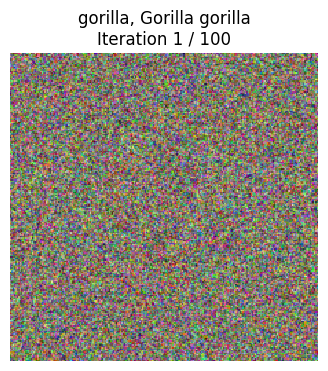

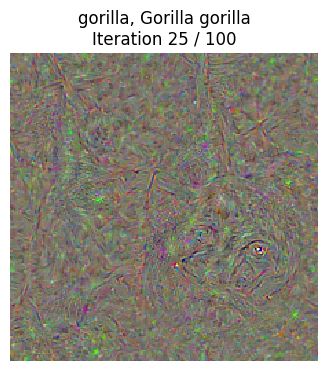

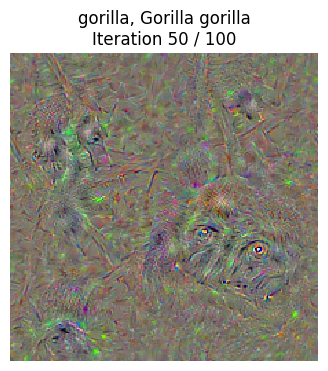

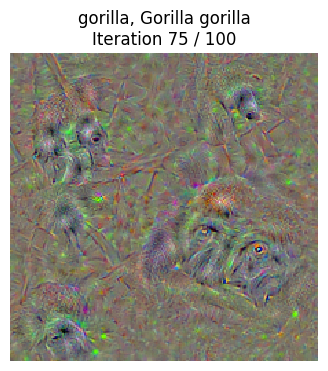

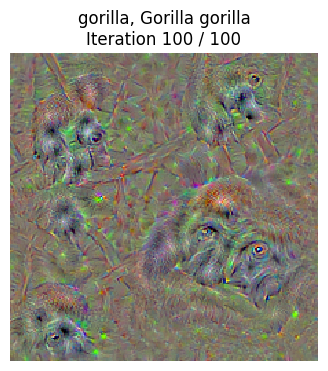

In [14]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
target_y = 366 # Gorilla
# target_y = 604 # Hourglass
#target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)